## Moduls

Tensorflow 2.0.0 + tf-hub 0.7.0, when using bert keras layer. The model will raise error when predict after compile and fit.  
Tensorflow 2.1.0 + tf-hub 0.7.0 works fine.

In [0]:
!pip install tensorflow-gpu==2.1.0
!pip install tensorflow_hub
!pip install bert-for-tf2
!pip install sentencepiece
!pip install matplotlib

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 450kB 54.9MB/s 
     |████████████████████████████████| 3.8MB 59.5MB/s 
     |████████████████████████████████| 81kB 13.9MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goo

     |████████████████████████████████| 40kB 2.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.13.4-cp36-none-any.whl size=29944 sha256=837d0e56d90ade367d68cb4fabd6c84350ce1e0ed516530074b02e25be884b86
  Stored in directory: /root/.cache/pip/wheels/d1/14/6d/b36f1618f939480ce5baa48e4d918ea00669f1cbbec4419514
  Created wheel for py-params: filename=py_params-0.8.2-cp36-none-any.whl size=4635 sha256=cd99cf30c7a66ae0ee24c6ee9160b2e83c3df97ab9e76ba1a9b98ef2a0bd16d9
  Stored in directory: /root/.cache/pip/wheels/83/3a/9c/baf35d6f17f0c2c6b61bf8ac3ab9fc12df0e41432ccaeecacb
  Created wheel for params-flow: filename=params_flow-0.7.4-cp36-none-any.whl size=16195 sha256=87e1dfdaab56e666123306fcf1a7d6d8cd3e501b68fb968f41856c682c1a903e
  Stored in directory: /root/.cache/pip/wheels/86/30/40/507b60d68b67ac87f35e95c98f5b296a32f146d5ae1d1d5aa7
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.0MB 3.4MB/s 


In [0]:
import tensorflow as tf
import tensorflow_hub as tfhub
import bert
import os
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [0]:
!wget https://raw.githubusercontent.com/ccuulinay/texts_semantic_sim/master/data/train.txt
!wget https://raw.githubusercontent.com/ccuulinay/texts_semantic_sim/master/data/test.txt

--2020-02-04 11:13:35--  https://raw.githubusercontent.com/ccuulinay/texts_semantic_sim/master/data/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5174256 (4.9M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   4.93M  17.4MB/s    in 0.3s    

2020-02-04 11:13:35 (17.4 MB/s) - ‘train.txt’ saved [5174256/5174256]

--2020-02-04 11:13:37--  https://raw.githubusercontent.com/ccuulinay/texts_semantic_sim/master/data/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2553277 (2.4M) [text/plain]

In [0]:
train_file = "train.txt"
test_file = "test.txt"

In [0]:


train = pd.read_csv(train_file, sep="\t", header=None, names=["q1", "q2", "label"])
test = pd.read_csv(test_file, sep="\t", header=None, names=["q1", "q2", "label"])

DATA_COLUMNS = ["q1", "q2"]
LABEL_COLUMN = ['label']

In [0]:
_train_0 = train[train['label'] == 0].sample(2500)
_train_1 = train[train['label'] == 1].sample(2500)
train = pd.concat([_train_0, _train_1])

_test_0 = test[test['label'] == 0].sample(2500)
_test_1 = test[test['label'] == 1].sample(2500)
test = pd.concat([_test_0, _test_1])


In [0]:
def get_masks(tokens, max_seq_length):
  """Mask for padding"""
  if len(tokens)>max_seq_length:
    raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))


def get_segments(tokens, max_seq_length):
  """Segments: 0 for the first sequence, 1 for the second"""
  if len(tokens)>max_seq_length:
      raise IndexError("Token length more than max seq length!")
  segments = []
  current_segment_id = 0
  for token in tokens:
      segments.append(current_segment_id)
      if token == "[SEP]":
          current_segment_id = 1
  return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
  """Token ids from Tokenizer vocab"""
  if len(tokens) > max_seq_length:
    raise IndexError("Token length more than max seq length!")
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
  return input_ids


def single_str2ids(s, tokenizer, max_seq_length):
  # input_ids=[0] * max_seq_length
  stokens = tokenizer.tokenize(s)
  if len(stokens) > max_seq_length - 2:
      stokens = stokens[0:(max_seq_length - 2)]
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
  input_ids = tokenizer.convert_tokens_to_ids(stokens)
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
  return input_ids


def sent2_bert_inputs(s, tokenizer, max_seq_length):
  stokens = tokenizer.tokenize(s)
  if len(stokens) > max_seq_length - 2:
      stokens = stokens[0:(max_seq_length - 2)]
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
  input_ids = tokenizer.convert_tokens_to_ids(stokens)
  input_mask = [1] * len(input_ids)

  segment_ids = []
  current_segment_id = 0
  for token in stokens:
      segment_ids.append(current_segment_id)
      if token == "[SEP]":
          current_segment_id = 1
  
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)
  return input_ids, input_mask, segment_ids


def bert_encode_inputs(sentences, tokenizer, max_seq_length):
  def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
      total_length = len(tokens_a) + len(tokens_b)
      if total_length <= max_length:
        break
      if len(tokens_a) > len(tokens_b):
        tokens_a.pop()
      else:
        tokens_b.pop()
  
  if len(sentences) >= 2:
    sentences = sentences[:2]
    s1 = sentences[0]
    s2 = sentences[1]

    tokens_a = tokenizer.tokenize(s1)
    tokens_b = tokenizer.tokenize(s2)
    _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
    tokens = []
    segment_ids = []

    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
      tokens.append(token)
      segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    for token in tokens_b:
      tokens.append(token)
      segment_ids.append(1)
    tokens.append("[SEP]")
    segment_ids.append(1)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
      input_ids.append(0)
      input_mask.append(0)
      segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    return input_ids, input_mask, segment_ids

  elif len(sentences) == 1:
    s = sentences[0]
    return sent2_bert_inputs(s, tokenizer, max_seq_length)
  else:
    print("No sentences input.")
    return

In [0]:
bert_layer = tfhub.KerasLayer("https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/1", trainable=True)

In [0]:
## Using bert-for-tf2 for tokenizer.
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
## Using repo tokenzier
## 1. Download tokenization from repo
# !wget https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

# import tokenization

## 2. Local model, take bert as example
## Download bert model
# !wget https://storage.googleapis.com/cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12.tar.gz
## Unzip the file
# !tar -zxvf uncased_L-12_H-768_A-12.tar.gz


## 3. Local download
# model_dir = "./home/hongkuny/public/pretrained_models/keras_bert/uncased_L-12_H-768_A-12"
# model_ckpt = os.path.join(model_dir, "bert_model.ckpt")

# vocab_file = os.path.join(model_dir, "30k-clean.vocab")
# spm_model = os.path.join(model_dir, "30k-clean.model")

# do_lower_case = True
# bert.albert_tokenization.validate_case_matches_checkpoint(do_lower_case, model_ckpt)
# tokenizer = bert.albert_tokenization.FullTokenizer(vocab_file, do_lower_case=do_lower_case)
# tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case=do_lower_case, spm_model_file=spm_model)

In [0]:
max_seq_len = 128

In [0]:
# a = bert_encode_inputs(train[DATA_COLUMNS].head().values.tolist()[0], tokenizer, max_seq_len)

In [0]:
train_set = []
for s in train[DATA_COLUMNS].values:
  train_set.append(bert_encode_inputs(s, tokenizer, max_seq_len))
train_features_df = pd.DataFrame(train_set, columns=['word_ids', 'mask', 'segment_ids'])

test_set = []
for s in test[DATA_COLUMNS].values:
  test_set.append(bert_encode_inputs(s, tokenizer, max_seq_len))
test_features_df = pd.DataFrame(test_set, columns=['word_ids', 'mask', 'segment_ids'])


train_features = {}
train_features['word_ids'] = np.array(train_features_df['word_ids'].values.tolist())
train_features['mask'] = np.array(train_features_df['mask'].values.tolist())
train_features['segment_ids'] = np.array(train_features_df['segment_ids'].values.tolist())

test_features = {}
test_features['word_ids'] = np.array(test_features_df['word_ids'].values.tolist())
test_features['mask'] = np.array(test_features_df['mask'].values.tolist())
test_features['segment_ids'] = np.array(test_features_df['segment_ids'].values.tolist())

val_features_df = test_features_df.iloc[:1000].copy()
val_features = {}
val_features['word_ids'] = np.array(val_features_df['word_ids'].values.tolist())
val_features['mask'] = np.array(val_features_df['mask'].values.tolist())
val_features['segment_ids'] = np.array(val_features_df['segment_ids'].values.tolist())

train_labels = train[LABEL_COLUMN].values
test_labels = test[LABEL_COLUMN].values
val_labels = test.iloc[:1000][LABEL_COLUMN].values


## Model

In [0]:
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 5

In [0]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
# pooled = GlobalAveragePooling1D(seq)


# logits = tf.keras.layers.Dense(64, activation=tf.nn.relu)(pooled_output)
# logits = tf.keras.layers.Dropout(0.5)(logits)
# logtis = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(logtis)
dense_1 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(pooled_output)

In [0]:
embed_model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[pooled_output, sequence_output])
cls = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=dense_1)

In [0]:


'''
# Sequential
cls = tf.keras.Sequential([
        # tf.keras.layers.Input(shape=(max_seq_length,), dtype='int32', name='input_ids'),
        [input_word_ids, input_mask, segment_ids],
        bert_layer,
        # tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(128, activation=tf.nn.relu),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        # tf.keras.layers.Dropout(0.5),
        # tf.keras.layers.Dense(1, activation=tf.nn.softmax)
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

cls.build(input_shape=(None, max_seq_len))
'''
cls.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(lr=LEARNING_RATE), metrics=['accuracy'])

# cls.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=LEARNING_RATE), metrics=['accuracy'])

print(cls.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 102267649   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [0]:
# Train
output_dir = "./"
checkpoint_name = os.path.join(output_dir, "bert_for_zh_texts_semantic.ckpt")

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_name,
                                                     save_weights_only=True,
                                                     verbose=1)
steps_per_epoch = int(round(len(train_set))//BATCH_SIZE)
val_steps = int(1000//BATCH_SIZE)
# callback = StopTrainingClassComplete()

history = cls.fit(
        (train_features['word_ids'], train_features['mask'],train_features['segment_ids']),
        train_labels,
        epochs=NUM_TRAIN_EPOCHS, # Will raise error when epoch number is float. 
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        # steps_per_epoch = steps_per_epoch,
        # validation_steps=val_steps,
        # validation_data=((val_features['word_ids'], val_features['mask'],val_features['segment_ids']), val_labels),
        verbose=1,
        # callbacks=[cp_callback]
)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
4000/4000 [==============================] - 110s 27ms/sample - loss: 0.3685 - accuracy: 0.8317 - val_loss: 0.5844 - val_accuracy: 0.7740
Epoch 2/5
4000/4000 [==============================] - 107s 27ms/sample - loss: 0.1636 - accuracy: 0.9448 - val_loss: 1.0429 - val_accuracy: 0.6880
Epoch 3/5
4000/4000 [==============================] - 107s 27ms/sample - loss: 0.0984 - accuracy: 0.9697 - val_loss: 0.7305 - val_accuracy: 0.7760
Epoch 4/5
4000/4000 [==============================] - 107s 27ms/sample - loss: 0.0639 - accuracy: 0.9800 - val_loss: 1.5015 - val_accuracy: 0.6290
Epoch 5/5
4000/4000 [==============================] - 107s 27ms/sample - loss: 0.0472 - accuracy: 0.9872 - val_loss: 0.7267 - val_accuracy: 0.8080


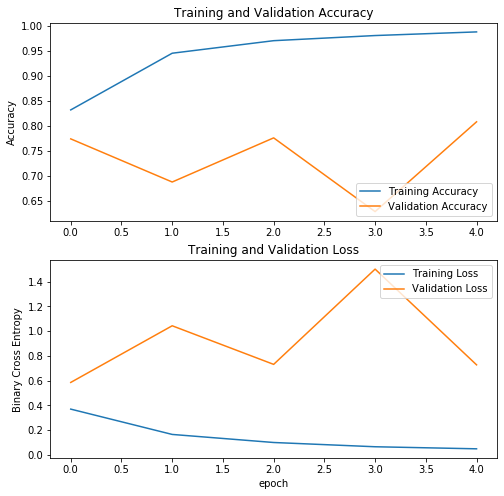

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score



In [0]:
# np.shape([test_features['word_ids'], test_features['mask'], test_features['segment_ids']])


In [0]:
loss_n_acc = cls.evaluate([test_features['word_ids'], test_features['mask'], test_features['segment_ids']], test_labels)

5000/5000 [==============================] - 46s 9ms/sample - loss: 0.9264 - accuracy: 0.7376


In [0]:
loss_n_acc

[0.9263997816562652, 0.7376]

In [0]:
test_prop = cls.predict((test_features['word_ids'], test_features['mask'], test_features['segment_ids']))
# train_features['word_ids'][0]

In [0]:
test_pred = np.where(test_prop > 0.5, 1, 0).flatten()

In [0]:
np.shape(test_labels)

(5000, 1)

In [0]:
cm = confusion_matrix(test_labels, test_pred)  
print(cm)  
print()
print("F1 score", f1_score(test_labels, test_pred))
print('Accuracy', accuracy_score(test_labels, test_pred))
print('ROC AUC SCORE', roc_auc_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))

[[1683  817]
 [ 495 2005]]

F1 score 0.7534761367906802
Accuracy 0.7376
ROC AUC SCORE 0.7376
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      2500
           1       0.71      0.80      0.75      2500

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000



In [0]:
## Save the model
# cls.save("zh_texts_semantic_cls_bert_3epoch.h5")

In [0]:
# tf.keras.models.save_model(cls, "zh_texts_semantic_cls_bert_3epoch.tf")

In [0]:
## Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# !cp zh_texts_semantic_cls_bert_3epoch.h5 /content/drive/My\ Drive/Colab\ Notebooks/

In [0]:
# reload_cls = tf.keras.models.load_model("zh_texts_semantic_cls_bert_3epoch.h5",custom_objects={'KerasLayer':tfhub.KerasLayer})

In [0]:
# reload_cls.summary()